<a href="https://colab.research.google.com/github/Locojuan9/se-ales_y_sistemas/blob/main/3_SerieyTransformadaFourier/Shazam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detector de género de canciones



1. Cargar base de datos
2. Importar/Descargar librerías para manejo de señales de audio
3. Leer base de datos
4. Procesar la BBDD
5. Almacenar espectros
6. Ingresar enlace de prueba
7. Aplicar Fourier
8. Comparar espectro con Cdist
9. Obtener argmin
10. Clasificar



#Tratamiento de la base de datos

* Instalación e importe de librerías

In [ ]:
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

In [ ]:
!pip install soundfile

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yt_dlp as youtube_dl
import subprocess
import os
import soundfile as sf
from IPython.display import Audio
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib
from google.colab import files
from datetime import date, datetime
import shutil

* Carga de la base de datos

In [ ]:
#cargar datos desde drive acceso libre
FILEID = "14ibLeuy1D3V15si0nrisKyTySJ23CHEV"

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O  canciones.xlsx && rm -rf /tmp/cookies.txt
#!unzip -o codigos.zip
!dir

* Lectura base de datos

In [ ]:
file_ = 'canciones.xlsx' # leer archivo xlsx con link, band, type, type_num
X  = pd.read_excel(file_)
X # imprimir filas iniciales

* Descarga de audios

In [7]:
#funcion para descargar mp3 desde youtube
def download_ytvid_as_mp3(video_url,name):
    #video_url = input("enter url of youtube video:")
    video_info = youtube_dl.YoutubeDL().extract_info(url = video_url,download=False)
    filename = f"{name}.mp3"
    options={
        'format':'bestaudio/best',
        'keepvideo':False,
        'outtmpl':filename,
    }

    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([video_info['webpage_url']])

    print("Download complete... {}".format(filename))

* Conversión de formato a .wav

In [ ]:
#crear carpeta con resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#recorrer excel con videos
N, P = X.shape # Filas, Columnas
Ns = N * 5 # Cantidad de segmentos por cancion

for n in range(N):
    print(f"video {n+1} de {N}")
    print(f"link: {X.loc[n,'link']}")
    print(f"band: {X.loc[n,'band']}")
    print(f"type: {X.loc[n,'type']}")
    #ruta video n-th
    name_ = 'results/'+X.loc[n,'band']+"_"+str(n)+"_"+str(X.loc[n,'type_num']) # #video+nombre+tipo de genero musical
    #descargar mp3 desde youtube
    download_ytvid_as_mp3(X.loc[n,'link'],name_)
    #convertir a .wav
    subprocess.call(['ffmpeg','-y', '-i', name_+'.mp3', name_+'.wav'])

    # Eliminar archivos innecesarios
    try:
        os.remove(f'{name_}.mp3')
        print('Archivo removido con éxito\n')
    except:
        print('El archivo ya ha sido removido\n')

* Archivos .wav contenidos en una lista

In [ ]:
#cargar .wavs y partir audios
#lista archivos .wav
path = 'results/'
wav_files = [f for f in os.listdir(path)]
wav_files

* Crear vectores de información de canciones

In [ ]:
fs = 48000 # Frecuencia de muestreo de YouTube
tl = np.array([40,50,60,70,80,90,100]) # Puntos de lectura (segundos en los que leerá el espectro de la canción)
ts = 5 # Duración de la muestra)
Ns = len(wav_files) * len(tl) # cantidad de muestras

x_t = np.zeros((Ns, int(ts*fs), 2)) #Ns filas, ts*fs columnas, 2 canales (stereo) por elemento
label = np.zeros((Ns, 1)) #vector tipo de genero
name_c = [] # Vector de nombres de las canciones

#leer archivos wav
i = 0 # Contador
for song in wav_files: # lectura audio .wav
    x, fs = sf.read(path+song) # song data, frecuencia de muestreo
    for lect in tl: #segmentos de tiempo
        x_t[i] = x[int(fs*lect):int(fs*(lect+ts)),:] # Guarda la muestra en el vector de songs data
        label[i] = int(song[-5]) # Guarda el tipo de genero
        name_c += [song[:-6]] # Guarda el nombre de la canción
        print(f"{i} lectura: {song}; segundo {lect}:{lect+ts}; tipo música {label[i]}")
        i+=1
x_t.shape

* Se analiza (por ejemplo) la muestra n° 11 (la cuenta empieza en 0) de las 140 muestras

In [19]:
i = 20
Audio(x_t[i].T,rate=fs)

* Procesado en Fourier

In [ ]:
#calculo de fourier
vf = np.fft.rfftfreq(x_t.shape[1],1/fs) #calculo vector de frecuencias
Xw = np.fft.rfft(x_t, axis=1).mean(axis=-1) #transformada rapida de Fourier para señal Real a lo largo del tiempo (axis=1 -> filas) y se promedian los dos canales
Xw.shape

* Plot de tiempo de ambos canales de cada canción

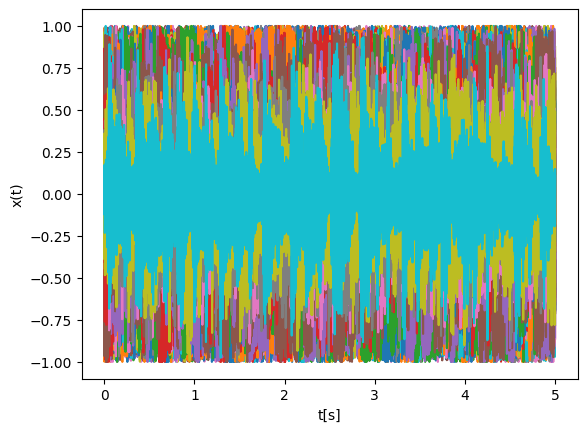

In [22]:
#grafica tiempo y fourier
plt.plot(np.arange(0,ts,1/fs), x_t.mean(axis=-1).T) #se promedian los dos canales stereo
plt.xlabel('t[s]')
plt.ylabel('x(t)')
plt.show()

* Plot del espectro de ambos canales de cada canción

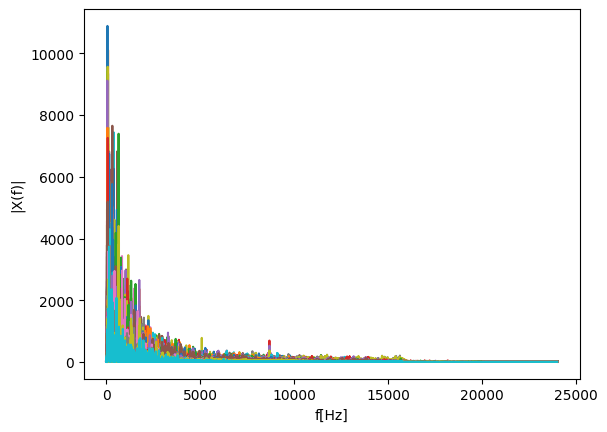

In [23]:
plt.plot(vf,abs(Xw).T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

In [ ]:
#se normalizan espectros entre 0 y 1 para evitar inconsistencias por ampliltudes máximas

sca = MinMaxScaler()
Xw_ = sca.fit_transform(abs(Xw).T).T

plt.plot(vf,Xw_.T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

#en dB
plt.plot(vf,(20*np.log10(Xw_+1e-10)).T) # se suma 1e-10 para evitar discontinuidad del log
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)| dB')
plt.show()

In [ ]:
#visualización de datos
red_ = TSNE(perplexity = 20,n_components=2,random_state=123,learning_rate='auto',init='pca')
#red_ = PCA(n_components=2,random_state=123)
fmax = 7000
X_2D = red_.fit_transform(Xw_[:,:fmax]) #se tiene en cuenta el espectro hasta fmax Hz

In [ ]:
#graficar separabilidad 2D
plt.scatter(X_2D[:,0],X_2D[:,1],c=label)
plt.colorbar()
plt.show()

color_ = ["b","y"]
#nombre cancion
plt.scatter(X_2D[:,0],X_2D[:,1],c=label,s=1)
for i, tex in enumerate(name_c):
    #print(f"{i} {tex}")
    plt.text(X_2D[i,0]*1.025,X_2D[i,1]*1.025, tex[:-2]+"_"+str(i), fontsize=6,color=color_[int(label[i]-1)])

#plt.colorbar()
plt.show()

In [ ]:
#reproducir audio
i = 96
Audio(x_t[i].T,rate=fs)

In [ ]:
i = 14
Audio(x_t[i].T,rate=fs)

In [ ]:

#guardar modelo
os.mkdir('modelo')
filename_ = 'modelo/reggaeton_vs_metal'
model_ ={'Xw_':Xw_,'fmax': fmax, 'label' : label, 'name_c' : name_c, 'vf':vf,'fs':fs}
joblib.dump(model_,filename_+".pkl")


In [ ]:
#descargar modelo
#guardar resultados

#guardar resultados
namefile = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))+'modelo'
shutil.make_archive(namefile, 'zip', 'modelo')
files.download(namefile+'.zip')

#el archivo .zip puede cargarse en drive y utilizarse en otro cuaderno para detectar género musical de nuevos segmentos

In [ ]:
#cargar modelo
my_model_loaded = joblib.load(filename_+".pkl")
my_model_loaded.keys()